# Sentiment Analysis and Hate-Speech Detection on Tweets

The following notebook consists of three main sections:
1. <b>Data Exploration and Preprocessing:</b> In this section the following datasets from Kaggle are explored and cleaned:
    - Sentiment Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140
    - Hate Speech Dataset: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
<br></br>
2. <b>Sentiment Classification Models:</b> In this section we build and train two models to classify sentiment data into the categories Negative and Positive
    - Naive Bayes
    - LSTM
<br></br>
3. <b>Application of Sentiment Classification Models on Hate Speech Data:</b> In this section we apply the previously trained models on hate speech data to determine if they perform well in identifying a predominant negative sentiment. Additionally, we apply a pretrained model called VADER, which was trained for Hate Speech detection.

In [1]:
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from helper_functions import *
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 1. Data Exploration and Preprocessing

## Sentiment Data

This dataset contains tweets tagged as Positive or Negative according to their predominant emotion.

In [2]:
df_sentiment=pd.read_csv('data/Sentiment140.csv', encoding='latin-1', header=None, index_col=False)
df_sentiment = df_sentiment[[0, 5]].rename(columns={0: "target", 5: "text"})
df_sentiment.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
df_sentiment.isnull().sum()

target    0
text      0
dtype: int64

In [4]:
# output the dataframe structure
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<AxesSubplot: >

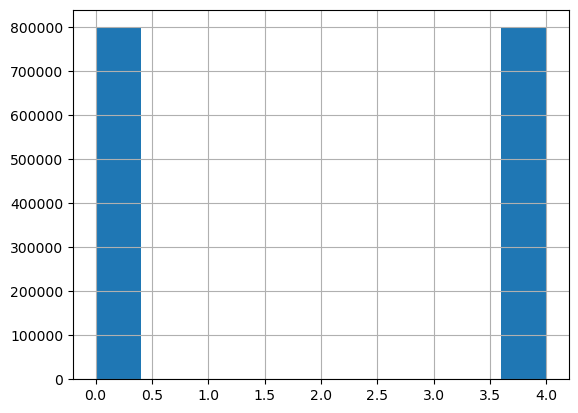

In [5]:
#Convert target to categorical
df_sentiment['target'] = pd.Categorical(df_sentiment.target)
df_sentiment['target'].unique()
df_sentiment['target'].hist()

In this dataset, target values describe the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive). However, there are only negative and positive tags (0 and 4) so let's change those values to 0 = negative, 1 = positive

<AxesSubplot: >

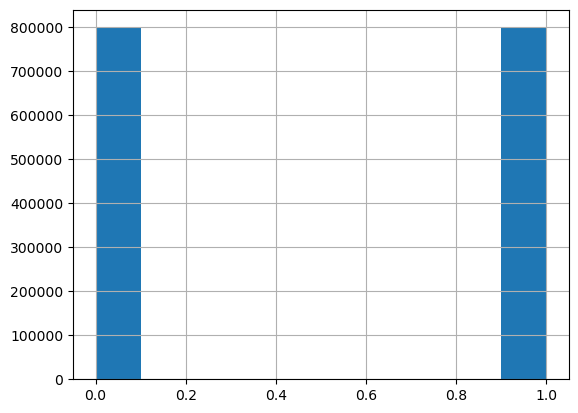

In [6]:
df_sentiment['target'] = df_sentiment['target'].replace(4,1) #Replace 4 (positive) by 1. Negative (0) remain the same
df_sentiment['target'].hist()

In [7]:
# # For testing purposes, get a sample of the data
# df_sentiment=df_sentiment.sample(500000)
# df_sentiment['target'].hist()

## Hate Speech Data

This dataset contains tweets tagged as Hate Speech, Offensive Language or Neither.

In [8]:
df_hate=pd.read_csv('data/HateSpeech_tweets.csv', encoding='latin-1', usecols  = ["class", "tweet"])
df_hate = df_hate.rename(columns={"class": "target", "tweet": "text"})
df_hate.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  24783 non-null  int64 
 1   text    24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [10]:
df_hate.isnull().sum()

target    0
text      0
dtype: int64

<AxesSubplot: >

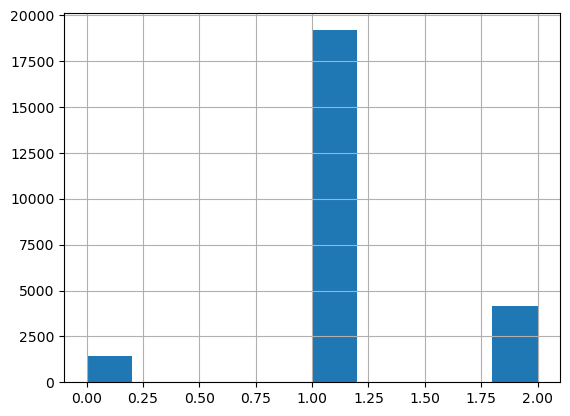

In [11]:
#Convert target to categorical
df_hate['target'] = pd.Categorical(df_hate.target)
df_hate['target'].unique()
df_hate['target'].hist()

In this dataset, target values describe the type of the tweet (0 - hate speech, 1 - offensive language, 2 - neither). 

However, for the desired task we are only interested in retrieving the hate speech and offensive language and identify a Negative Sentiment. 


Thus, we will remove the non-offensive text rows (tagged as 2-neither) and combine hate speech (0) and offensive language (1) into the same category 0, which is the value we used when traning the model to tag a Negative sentiment.

<AxesSubplot: >

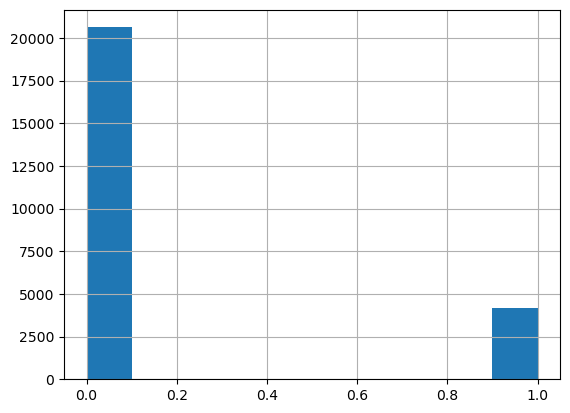

In [12]:
df_hate['target'] = df_hate['target'].replace(1,0) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
df_hate['target'] = df_hate['target'].replace(2,1) #Replace 2 (neither) by 1
#df_hate = df_hate[df_hate['target'] == 0] #Keep only the rows with hate/offensive tweets
df_hate['target'].hist()

In [13]:
# Separate text from labels
X_hate=df_hate['text']
y_hate=df_hate['target']

## Data Cleaning Pipeline

In [14]:
cleaning=[('cleaner', FunctionTransformer(data_cleaning))]
data_cleaning_pipeline=Pipeline(cleaning)

## Sentiment Data Train/Test Split

The sentiment data will be used to train our classification models, so we ned to split it into train, validation and test.

In [15]:
# Split in training set and, testing set and separate labels from data
X_sentiment=df_sentiment['text']
y_sentiment=df_sentiment['target']

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Split in training set and, testing set and separate labels from data
X_train, X_test, y_train, y_test= train_test_split(X_sentiment, y_sentiment, test_size = 1 - train_ratio, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=validation_ratio/(test_ratio + validation_ratio), random_state = 0)

len(X_train), len(X_val), len(X_test)

(1200000, 240000, 160000)

## Sentiment Data Cleaning

In [16]:
t1 = time.time()

X_train_clean=data_cleaning_pipeline.fit_transform(X_train)

t2 = time.time()
print(t2 - t1)

115.48527193069458


In [17]:
t1 = time.time()

X_val_clean=data_cleaning_pipeline.fit_transform(X_val)

t2 = time.time()
print(t2 - t1)

23.0193772315979


In [18]:
t1 = time.time()

X_test_clean=data_cleaning_pipeline.fit_transform(X_test)

t2 = time.time()
print(t2 - t1)

15.432088136672974


## Hate Speech Data Cleaning Pipeline

Hate Speech data will only be used to evaluate the performance of the different models on hate speech. It wont be involved in the training phase.

In [19]:
t1 = time.time()

X_hate_clean=data_cleaning_pipeline.fit_transform(X_hate)

t2 = time.time()
print(t2 - t1)

2.499497890472412


# 2. Sentiment Classification Models

## Naive Bayes Model

### Further Preprocessing on Sentiment Data

##### Build TFIDF pipeline

In [20]:
# Build TfidfVectorizer Pipeline
tfidf=[('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 2)))] #TODO Check these values
tfidf_pipeline=Pipeline(tfidf)

##### Appply TFIDF pipeline on Sentiment Data

In [21]:
#Apply TFIDF pipeline to the training set
t1 = time.time()

X_train_transformed=tfidf_pipeline.fit_transform(X_train_clean)

t2 = time.time()
print(t2 - t1)

31.89166498184204


In [22]:
#Apply TFIDF pipeline to the validation set
t1 = time.time()

X_val_transformed=tfidf_pipeline.fit_transform(X_val_clean)

t2 = time.time()
print(t2 - t1)

7.016978025436401


In [23]:
#Apply TFIDF pipeline to the test set
t1 = time.time()

X_test_transformed=tfidf_pipeline.transform(X_test_clean)

t2 = time.time()
print(t2 - t1)

2.61114501953125


### Train and Optimize Naive Bayes

In [24]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search Parameters
param_grid = {'alpha': list(np.arange(0.00001, 1, 0.025))}

# Create a Naive Bayes model and fit the training data
nb = MultinomialNB()
random_search = RandomizedSearchCV(nb, param_grid, cv = 5, n_iter = 5, random_state = 0)
random_search.fit(X_train_transformed, y_train) 

# Results from Random Search Process
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", random_search.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search.best_score_)

 Results from Random Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=0.62501)

 The best score across ALL searched params:
 0.7976933333333334


In [25]:
naive_bayes_model = random_search.best_estimator_

### Evaluate Naive Bayes

In [26]:
# Generate Predictions for Trin and Test sets
nb_train_pred = naive_bayes_model.predict(X_train_transformed)
nb_test_pred = naive_bayes_model.predict(X_test_transformed)
nb_val_pred = naive_bayes_model.predict(X_val_transformed)

Results: Naive Bayes Model - sentiment, training set
Accuracy: 0.812615
F1: 0.810788159681727
Precision: 0.818400489230142
Recall: 0.8033161368206572

Results: Naive Bayes Model - sentiment, validation set
Accuracy: 0.5778208333333333
F1: 0.5753240928961519
Precision: 0.5793476609322507
Recall: 0.5713560267392589

Results: Naive Bayes Model - sentiment, testing set
Accuracy: 0.577675
F1: 0.5744997040414089
Precision: 0.5799041480746984
Recall: 0.5691950638234157


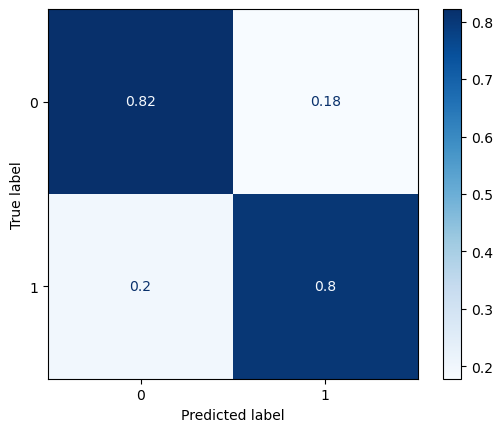

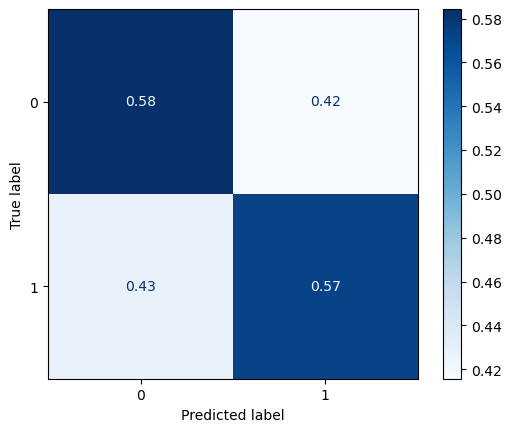

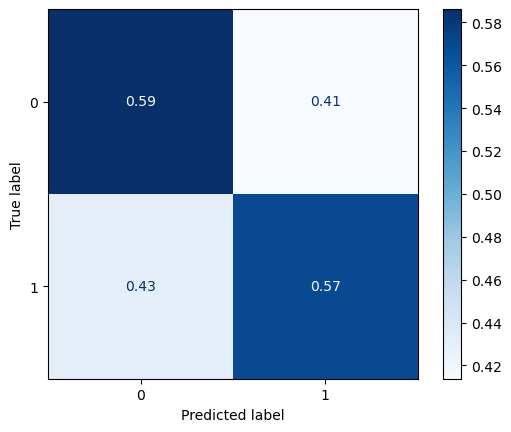

In [27]:
#labels = ["negative", "positive"]
# Evaluate the Naive Bayes model
print("Results: Naive Bayes Model - sentiment, training set")
evaluate(y_train, nb_train_pred)
print()
print("Results: Naive Bayes Model - sentiment, validation set")
evaluate(y_val, nb_val_pred)
print()
print("Results: Naive Bayes Model - sentiment, testing set")
evaluate(y_test, nb_test_pred)

## LSTM 

Referenced: 
* Keras Using pre-trained word embeddings: https://keras.io/examples/nlp/pretrained_word_embeddings/
* https://towardsdatascience.com/sentiment-analysis-comparing-3-common-approaches-naive-bayes-lstm-and-vader-ab561f834f89


In [28]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras import layers

### Further Preprocessing on Sentiment Data

In [29]:
tokenizer=Tokenizer() # change to the non-deprecated tf.keras.layers.TextVectorization 
tokenizer.fit_on_texts(X_train_clean)
vocab_size=len(tokenizer.word_index)+1
print(f'Vocab Size: {vocab_size}')

Vocab Size: 501018


In [30]:
def lstm_preprocessing(X, y, tokenizer, maxlen = 43):
    X_processed = pad_sequences(tokenizer.texts_to_sequences(X), maxlen)
    y_processed = to_categorical(y)
    return (X_processed, y_processed)

# Apply preprocessing to train and validation sets
X_train_processed, y_train_processed = lstm_preprocessing(X_train_clean, y_train, tokenizer)
X_val_processed, y_val_processed = lstm_preprocessing(X_val_clean, y_val, tokenizer)

#### GLoVE Embedding

Download glove.twitter.27B from https://nlp.stanford.edu/projects/glove/

In [31]:
def get_embeddings_dict(file): 
    embeddings_dict = {}
    with open(file, 'r' , encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_dict[word] = coefs
    return(embeddings_dict)

path_to_glove_file = "./data/glove.twitter.27B/glove.twitter.27B.50d.txt"
embeddings_dict = get_embeddings_dict(path_to_glove_file)

In [32]:
# Create embedding matrix
num_tokens = vocab_size
embedding_dim = 50
hits = 0 
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items(): 
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        hits += 1
    else: 
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 118643 words (382374 misses)


### LSTM Model without GLoVE embeddings

#### Train

In [33]:
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,\
                           output_dim=50,\
                           input_length=43)) 
model.add(layers.Dropout(0.5)) #added dropout layer to address overfitting
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train_processed,\
              y_train_processed,\
              batch_size=256,\
              epochs=2,\
              validation_data=(X_val_processed,y_val_processed))

2022-12-07 15:36:04.669056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 50)            25050900  
                                                                 
 dropout (Dropout)           (None, 43, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 25,111,502
Trainable params: 25,111,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
4688/4688 [==============================] - 643s 137ms/step - loss: 0.4398 - accuracy: 0.7943 - val_loss: 0.3975 - val_accuracy: 0.8193
Epoch 2/2
4688/4688 [========

In [34]:
from tensorflow import keras
model_path = f"model_{df_sentiment.shape[0]}_7Dec22"
model.save(model_path)
# model_GLoVE = keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: model_1600000_7Dec22/assets


#### Evaluate LSTM Model

In [35]:
# Preprocess test data
X_test_processed, y_test_processed = lstm_preprocessing(X_test_clean, y_test, tokenizer)

In [36]:
# Generate predictions for sentiment data
predictions_sentiment = model.predict(X_test_processed)
predictions_sentiment = prediction_probs_to_target(predictions_sentiment)

5000/5000 [==============================] - 28s 5ms/step


Accuracy: 0.8210875
F1: 0.8201409919702434
Precision: 0.825995064228311
Recall: 0.8143693148497062


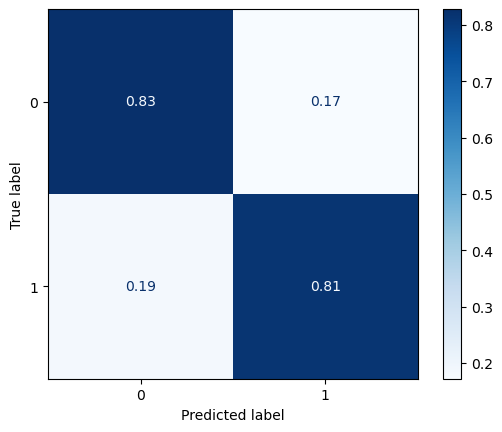

In [37]:
# Evaluate model on test data
evaluate(y_test, predictions_sentiment)

### LSTM Model with GLoVE embeddings

### Train LSTM

In [38]:
model_GLoVE=Sequential()
model_GLoVE.add(layers.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length = 43, trainable=False))       
model_GLoVE.add(layers.Dropout(0.5)) #added dropout layer to address overfitting
model_GLoVE.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_GLoVE.add(layers.Dense(2,activation='sigmoid'))
model_GLoVE.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

model_GLoVE.summary()

history = model_GLoVE.fit(X_train_processed,\
              y_train_processed,\
              batch_size=256,\
              epochs=5,\
              validation_data=(X_val_processed,y_val_processed))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 43, 50)            25050900  
                                                                 
 dropout_1 (Dropout)         (None, 43, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 25,111,502
Trainable params: 60,602
Non-trainable params: 25,050,900
_________________________________________________________________
Epoch 1/5
4688/4688 [==============================] - 322s 68ms/step - loss: 0.5610 - accuracy: 0.7055 - val_loss: 0.4806 - val_accuracy: 0.7681
Epoch 2/5
4688/4688 [==

In [39]:
from tensorflow import keras
model_glove_path = f"model_glove_{df_sentiment.shape[0]}_7Dec22"
model_GLoVE.save(model_glove_path)
# model_GLoVE = keras.models.load_model(model_glove_path)

INFO:tensorflow:Assets written to: model_glove_1600000_7Dec22/assets


### Evaluate LSTM Model

In [40]:
# Preprocess test data
X_test_processed, y_test_processed = lstm_preprocessing(X_test_clean, y_test, tokenizer)

In [41]:
# Generate predictions for sentiment data
predictions_sentiment = model_GLoVE.predict(X_test_processed)
predictions_sentiment = prediction_probs_to_target(predictions_sentiment)

5000/5000 [==============================] - 28s 6ms/step


Accuracy: 0.7874
F1: 0.7788411526058462
Precision: 0.8130862689201113
Recall: 0.7473640866950326


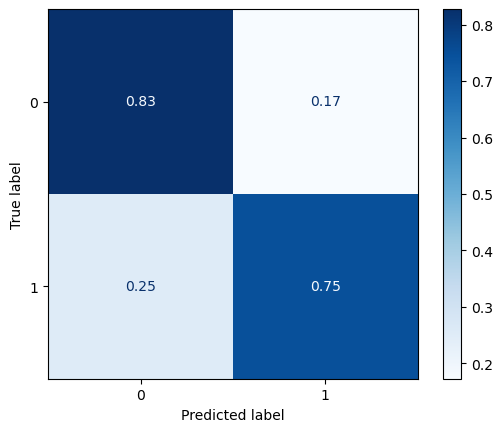

In [42]:
# Evaluate model on test data
evaluate(y_test, predictions_sentiment)

# 3. Application of Sentiment Classification Models on Hate Speech Data

## Hate Speech Detection with Naive Bayes

### Apply specific Naive Bayes preprocessing on the data

In [43]:
#Apply TFIDF on Hate Speech data
t1 = time.time()

X_hate_transformed=tfidf_pipeline.transform(X_hate_clean)

t2 = time.time()
print(t2 - t1)

0.5712769031524658


### Make predictions

In [44]:
# Generate predictions
t1 = time.time()

nb_hate_pred = naive_bayes_model.predict(X_hate_transformed)

t2 = time.time()
print(t2 - t1)

0.01205301284790039


### Evaluate

Accuracy: 0.5651051123754186
F1: 0.2901738672286618
Precision: 0.1998911169585337
Recall: 0.5291856834013933


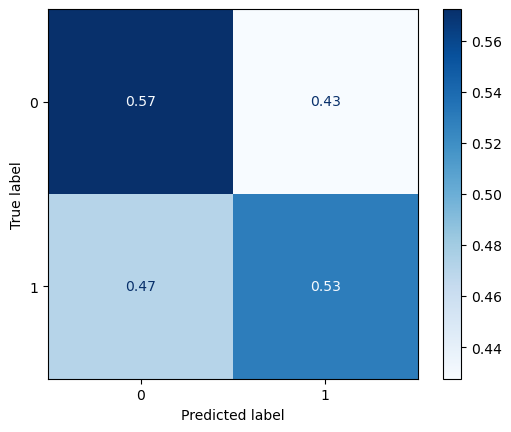

In [45]:
evaluate(y_hate, nb_hate_pred)

## Hate Speech Detection with LSTM Model

#### Apply specific LSTM preprocessing on the data

In [46]:
X_hate_processed, y_hate_processed = lstm_preprocessing(X_hate_clean, y_hate, tokenizer)

### LSTM without GloVe Embedings

#### Make Predictions

In [47]:
predictions_hate = model.predict(X_hate_processed)
predictions_hate = prediction_probs_to_target(predictions_hate)

775/775 [==============================] - 5s 6ms/step


#### Evaluate

Accuracy: 0.4683452366541581
F1: 0.2853888708102831
Precision: 0.18430823117338002
Recall: 0.6319961566178237


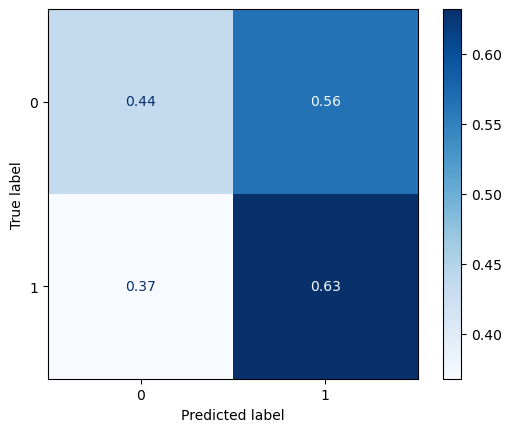

In [48]:
evaluate(y_hate, predictions_hate)

### LSTM with GloVe Embedings

#### Make Predictions

In [49]:
predictions_hate = model_GLoVE.predict(X_hate_processed)
predictions_hate = prediction_probs_to_target(predictions_hate)

775/775 [==============================] - 4s 6ms/step


#### Evaluate

Accuracy: 0.5025622402453295
F1: 0.2985889849795175
Precision: 0.1956311041526877
Recall: 0.6303146769156858


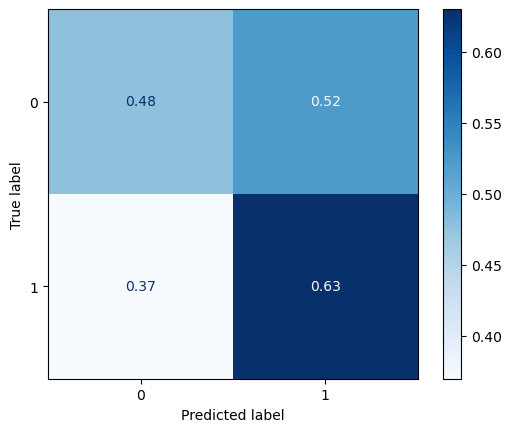

In [50]:
evaluate(y_hate, predictions_hate)

## Hate Speech Detection with VADER

In [51]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt

According to the academic paper on VADER, the Valence score is measured on a scale from -4 to +4, where -4 stands for the most 'Negative' sentiment and +4 for the most 'Positive' sentiment. Let's set the following ranges for defining the polarity of the text:

- From -4 to 0: Negative --> 0
- From 0 to 4: Positive --> 1

In [52]:
def apply_vader(data, threshold = 0, plot = True, evaluate = True):
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data.apply(lambda x: analyzer.polarity_scores(x['text'])['compound'], axis=1)
    if plot: 
        fig, ax = plt.subplots(figsize =(5, 3))
        ax.hist(data['vader'])
        plt.show()
    if evaluate: 
        data['predicted_target']=data.apply(lambda x: 0 if x['vader'] <= threshold else 1, axis=1)
        accuracy = accuracy_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        f1 = f1_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        precision = precision_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        recall = recall_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        plot_confusion_matrix(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        print(f'Accuracy: {accuracy}')    
        print(f'F1: {f1}')   
        print(f'Precision: {precision}')    
        print(f'Recall: {recall}')  

### Evaluate VADER on Sentiment Data

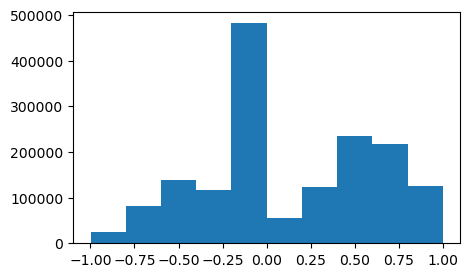

Accuracy: 0.6525475
F1: 0.6431759626901021
Precision: 0.6610046729588458
Recall: 0.62628375


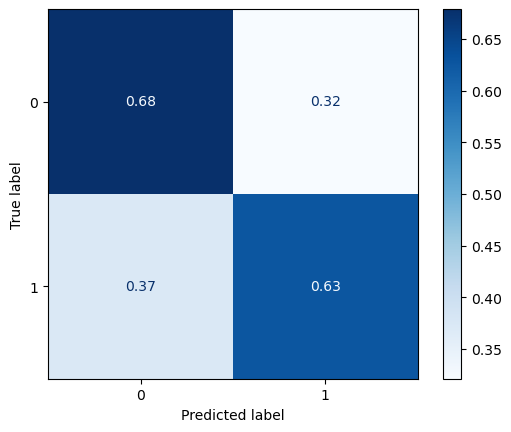

In [53]:
df_vader_sentiment = df_sentiment
apply_vader(df_vader_sentiment)

### Evaluate VADER on Hate Speech Data

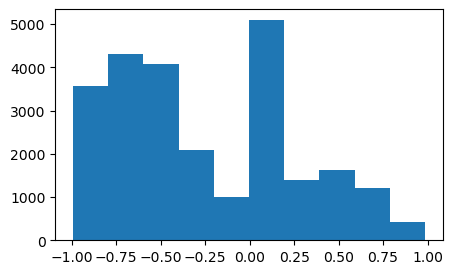

Accuracy: 0.7401041036194166
F1: 0.33823076132744273
Precision: 0.29551166965888687
Recall: 0.3953879413884218


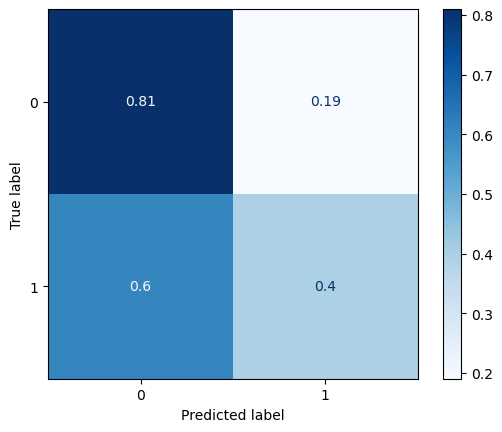

In [54]:
df_vader_hate = df_hate 
apply_vader(df_vader_hate)